## Bapco Energies 8 Hours of Bahrain (2025)

### Circuit Info
![Circuit Map](../../assets/Bahrain_Map.png)

In [76]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path


ROOT_PATH = Path("/Users/purplelightning/Development/Racing-all-Along")
DATASET_PATH = ROOT_PATH / "data/WEC/Bahrain_2025"
if DATASET_PATH.exists():
    print("Data Access Successful")
else:
    print("Path needs fixing")

Data Access Successful


### Loading the Dataset

In [77]:
# Contextual Names for the cols.
renamed_cols = {
    'NUMBER': "Car_Number",
    ' DRIVER_NUMBER': "Driver_Number",
    ' LAP_NUMBER': "Lap_Number",
    ' LAP_TIME': "Lap_Time",
    ' LAP_IMPROVEMENT': "Lap_Improvement",
    ' CROSSING_FINISH_LINE_IN_PIT': "Crossing_Finish_Line_In_Pit",
    ' S1': "S1",
    ' S1_IMPROVEMENT': "S1_Improvement",
    ' S2': "S2",
    ' S2_IMPROVEMENT': "S2_Improvement",
    ' S3': "S3",
    ' S3_IMPROVEMENT': "S3_Improvement",
    ' KPH': "Average_Lap_Speed",
    ' ELAPSED': "Session_Time_Elapsed",
    ' HOUR': "Track_Time",
    'S1_LARGE': "S1_in_mins",
    'S2_LARGE': "S2_in_mins",
    'S3_LARGE': "S3_in_mins",
    'TOP_SPEED': "Top_Speed",
    'DRIVER_NAME': "Driver_Name",
    'PIT_TIME': "Pit_Time",
    'CLASS': "Class",
    'GROUP': "Group",
    'TEAM': "Team_Name",
    'MANUFACTURER': "Manufacturer_Name",
    'FLAG_AT_FL': "Flag_at_Finish",
}

# Loading the Dataframe
quali_data = pl.read_csv(DATASET_PATH / "analysis_quali.csv", separator=";")

# Renaming the cols
quali_data = quali_data.rename(mapping=renamed_cols)

# Removing the default unnecessary cols
drop_cols = ['', 'Lap_Improvement', 'S1_in_mins', 'S2_in_mins', 'S3_in_mins', 'Class', 'Group', 'S1_SECONDS', 'S2_SECONDS', 'S3_SECONDS']
quali_data = quali_data.drop(*drop_cols)
quali_data.head()

Car_Number,Driver_Number,Lap_Number,Lap_Time,Crossing_Finish_Line_In_Pit,S1,S1_Improvement,S2,S2_Improvement,S3,S3_Improvement,Average_Lap_Speed,Session_Time_Elapsed,Track_Time,Top_Speed,Driver_Name,Pit_Time,Team_Name,Manufacturer_Name,Flag_at_Finish
i64,i64,i64,str,str,str,i64,f64,i64,f64,i64,f64,str,str,f64,str,str,str,str,str
7,3,1,"""3:57.557""",null,"""2:34.134""",0,46.875,0,36.548,0,78.2,"""3:57.557""","""16:43:57.557""",135.8,"""Ross GUNN""","""0:01:51.728""","""Aston Martin Thor Team""","""Aston Martin""","""GF"""
7,3,2,"""1:56.737""",null,"""37.392""",0,43.19,0,36.155,0,166.9,"""5:54.294""","""16:45:54.294""",228.1,"""Ross GUNN""",null,"""Aston Martin Thor Team""","""Aston Martin""","""GF"""
7,3,3,"""1:47.290""",null,"""34.353""",2,39.763,2,33.174,3,181.6,"""7:41.584""","""16:47:41.584""",286.7,"""Ross GUNN""",null,"""Aston Martin Thor Team""","""Aston Martin""","""GF"""
7,3,4,"""2:18.033""","""B""","""43.661""",0,48.108,0,46.264,0,141.1,"""9:59.617""","""16:49:59.617""",219.8,"""Ross GUNN""",null,"""Aston Martin Thor Team""","""Aston Martin""","""GF"""
9,2,1,"""3:50.680""",null,"""2:28.171""",0,47.094,0,35.415,0,80.6,"""3:50.680""","""16:43:50.680""",146.0,"""Marco SORENSEN""","""0:01:47.827""","""Aston Martin Thor Team""","""Aston Martin""","""GF"""


### Data Preprocessing

**Converting the Long-Format Times into Seconds**

In [78]:
def map_mins_to_secs(time_str: str) -> float | None:
    """Converts all time columns from string to the appropriate int / float."""

    # Empty Value
    if time_str is None:
        return None

    if ":" not in time_str:
        return round(float(time_str), 3)

    # Splitting the initial string
    time_parts = time_str.split(":")
    
    # Time passed does not contain hrs.
    if len(time_parts) == 2:
        mins, secs = map(lambda x: float(x), time_parts)
        return round(secs + (mins * 60), 3)
    # Time passed does contain hrs.
    elif len(time_parts) == 3:
        hrs, mins, secs = map(lambda x: float(x), time_parts)
        return round(secs + (hrs * 3600) + (mins * 60), 3)
    else:
        return None


# Time Cols that need to be converted from string to a number representing seconds.
time_cols_to_secs = ["Lap_Time", "S1", "Session_Time_Elapsed", "Pit_Time"]
quali_data = quali_data.with_columns(
    pl.col("Lap_Time").map_elements(map_mins_to_secs, return_dtype=pl.Float64).alias("Lap_Time"),
    pl.col("S1").map_elements(map_mins_to_secs, return_dtype=pl.Float64).alias("S1"),
    pl.col("Session_Time_Elapsed").map_elements(map_mins_to_secs, return_dtype=pl.Float64).alias("Session_Time_Elapsed"),
    pl.col("Pit_Time").map_elements(map_mins_to_secs, return_dtype=pl.Float64).alias("Pit_Time"),
)

quali_data.head()

Car_Number,Driver_Number,Lap_Number,Lap_Time,Crossing_Finish_Line_In_Pit,S1,S1_Improvement,S2,S2_Improvement,S3,S3_Improvement,Average_Lap_Speed,Session_Time_Elapsed,Track_Time,Top_Speed,Driver_Name,Pit_Time,Team_Name,Manufacturer_Name,Flag_at_Finish
i64,i64,i64,f64,str,f64,i64,f64,i64,f64,i64,f64,f64,str,f64,str,f64,str,str,str
7,3,1,237.557,null,154.134,0,46.875,0,36.548,0,78.2,237.557,"""16:43:57.557""",135.8,"""Ross GUNN""",111.728,"""Aston Martin Thor Team""","""Aston Martin""","""GF"""
7,3,2,116.737,null,37.392,0,43.19,0,36.155,0,166.9,354.294,"""16:45:54.294""",228.1,"""Ross GUNN""",null,"""Aston Martin Thor Team""","""Aston Martin""","""GF"""
7,3,3,107.29,null,34.353,2,39.763,2,33.174,3,181.6,461.584,"""16:47:41.584""",286.7,"""Ross GUNN""",null,"""Aston Martin Thor Team""","""Aston Martin""","""GF"""
7,3,4,138.033,"""B""",43.661,0,48.108,0,46.264,0,141.1,599.617,"""16:49:59.617""",219.8,"""Ross GUNN""",null,"""Aston Martin Thor Team""","""Aston Martin""","""GF"""
9,2,1,230.68,null,148.171,0,47.094,0,35.415,0,80.6,230.68,"""16:43:50.680""",146.0,"""Marco SORENSEN""",107.827,"""Aston Martin Thor Team""","""Aston Martin""","""GF"""


**Creating the Laps Into Stint (Tyre Age)**

In [ ]:
quali_data.select(
    pl.col("Pit_Time"),
    pl.when(pl.col("Pit_Time") == pl.Null)
    .then(pl.lit(False))
    .otherwise(pl.lit(True))
    .alias("Stint_Mask")
)

TypeError: cannot create expression literal for value of type DataTypeClass.

Hint: Pass `allow_object=True` to accept any value and create a literal of type Object.

**Exploratory Data Analysis**

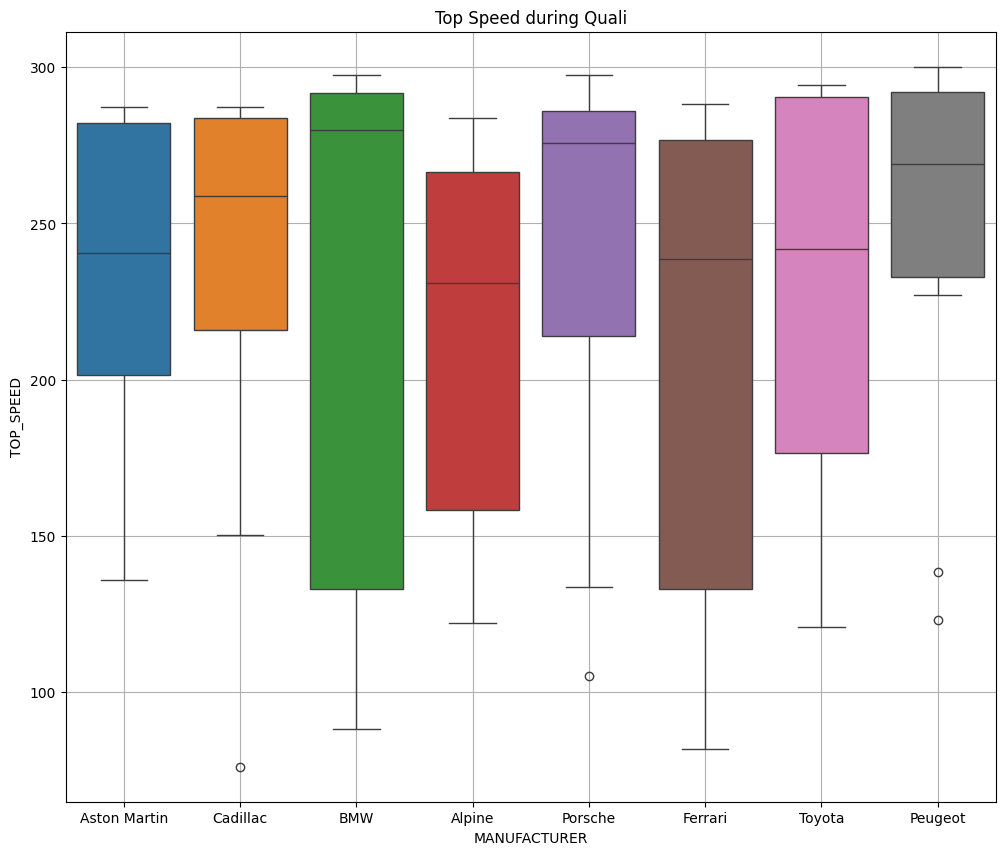

In [30]:
fig = plt.figure(figsize=(12, 10))
sns.boxplot(data=quali_data, x="MANUFACTURER", y="TOP_SPEED", hue="MANUFACTURER")
plt.title("Top Speed during Quali")
plt.grid()
plt.show()

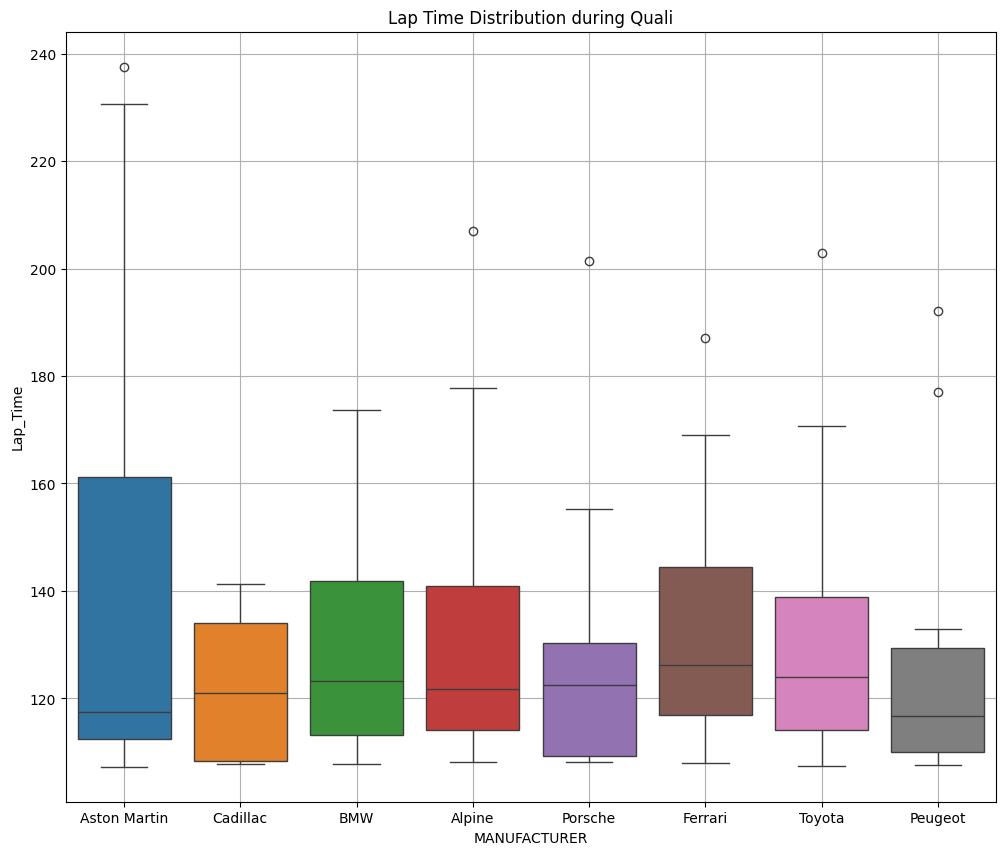

In [33]:
# Helper Function
def map_secs(lap_time: str) -> float:
    secs, millis = lap_time.split(".")
    mins, secs = secs.split(":")
    secs = float(secs)
    secs += float(millis) * 10 ** -3
    secs += (float(mins) * 60)
    return secs

# # Converting Laptime to Seconds
quali_data = quali_data.with_columns(
    pl.col(" LAP_TIME")
    .map_elements(map_secs, return_dtype=pl.Float64)
    .alias("Lap_Time")
)

# Visualising the Laptime Distribution
fig = plt.figure(figsize=(12, 10))
sns.boxplot(data=quali_data, x="MANUFACTURER", y="Lap_Time", hue="MANUFACTURER")
plt.title("Lap Time Distribution during Quali")
plt.grid()
plt.show()